This notebook shows how load a normalizing flow into a Creator object, and draw samples of galaxy redshifts, magnitudes, and conditional pdf's.

In [1]:
from creator import Creator
from normalizingFlow import NormalizingFlow
from rqNeuralSplineFlow import RQNeuralSplineFlow

In [2]:
%config InlineBackend.figure_format = 'retina'

First, load the generator, which in this case will be the normalizing flow created in `redshift_flow_example.ipynb`

In [3]:
# load the generator
flow = NormalizingFlow(RQNeuralSplineFlow, file='demo_flow.pkl')

In [4]:
# instantiate the creator
creator = Creator(flow)

Now let's draw 10k samples from the flow

In [5]:
%%time 
# draw the samples
samples = creator.sample(5000, include_pdf=False, seed=0)

CPU times: user 8.93 s, sys: 349 ms, total: 9.28 s
Wall time: 8.16 s


In [6]:
# print the first few
samples.head()

,redshift,u,g,r,i,z,y
0,0.922039,27.990791,26.757797,24.649775,23.520554,22.645355,22.313553
1,1.839557,30.705853,29.814680,28.595322,27.466633,26.012596,25.359596
2,0.245878,24.226664,23.418255,22.881210,22.723536,22.576611,22.582161
3,0.384001,26.785580,26.521791,25.988678,25.979652,25.743872,25.903984
4,1.174314,27.224506,26.878551,26.307793,25.771839,25.140873,24.712973


In [7]:
# get size of the samples
nMB = samples.memory_usage(index=True).sum()/1e6
print(f'size of samples in memory is {nMB:.3f} MB')

size of samples in memory is 0.140 MB


Let's draw the same sample, but this time get the conditional pdf's as well.

In [8]:
%%time
# draw the samples and include pdf's
samples_wPDF = creator.sample(5000, include_pdf=True, seed=0)

CPU times: user 4min 39s, sys: 3min 20s, total: 7min 59s
Wall time: 1min 32s


A few samples have redshift < 0. Cut these out. Might want to make sure this doesn't occur in the future...

In [9]:
samples_wPDF = samples_wPDF[samples_wPDF['redshift'] > 0]

In [10]:
import numpy as np
samples_wPDF.attrs['pz_grid'] = np.arange(0, 2.02, 0.02)

In [11]:
# print the first few
samples_wPDF.head()

,redshift,u,g,r,i,z,y,pz_pdf
0,0.922039,27.990791,26.757797,24.649775,23.520554,22.645355,22.313553,"[2.735362e-16, 3.6148057e-16, 4.864791e-16, 6...."
1,1.839557,30.705853,29.814680,28.595322,27.466633,26.012596,25.359596,"[3.8261596e-24, 5.665904e-24, 8.578127e-24, 1...."
2,0.245878,24.226664,23.418255,22.881210,22.723536,22.576611,22.582161,"[1.5244021e-08, 4.9384973e-08, 2.1365696e-07, ..."
3,0.384001,26.785580,26.521791,25.988678,25.979652,25.743872,25.903984,"[7.729578e-15, 1.0663126e-14, 1.4599385e-14, 1..."
4,1.174314,27.224506,26.878551,26.307793,25.771839,25.140873,24.712973,"[1.051479e-09, 1.1298188e-09, 1.1983603e-09, 1..."


In [12]:
# get size of the samples w pdf's
nMB = samples_wPDF.memory_usage(index=True).sum()/1e6
print(f'size of samples_wPDF in memory is {nMB:.3f} MB')

size of samples_wPDF in memory is 0.220 MB


Lets plot a few of the pdf's

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches

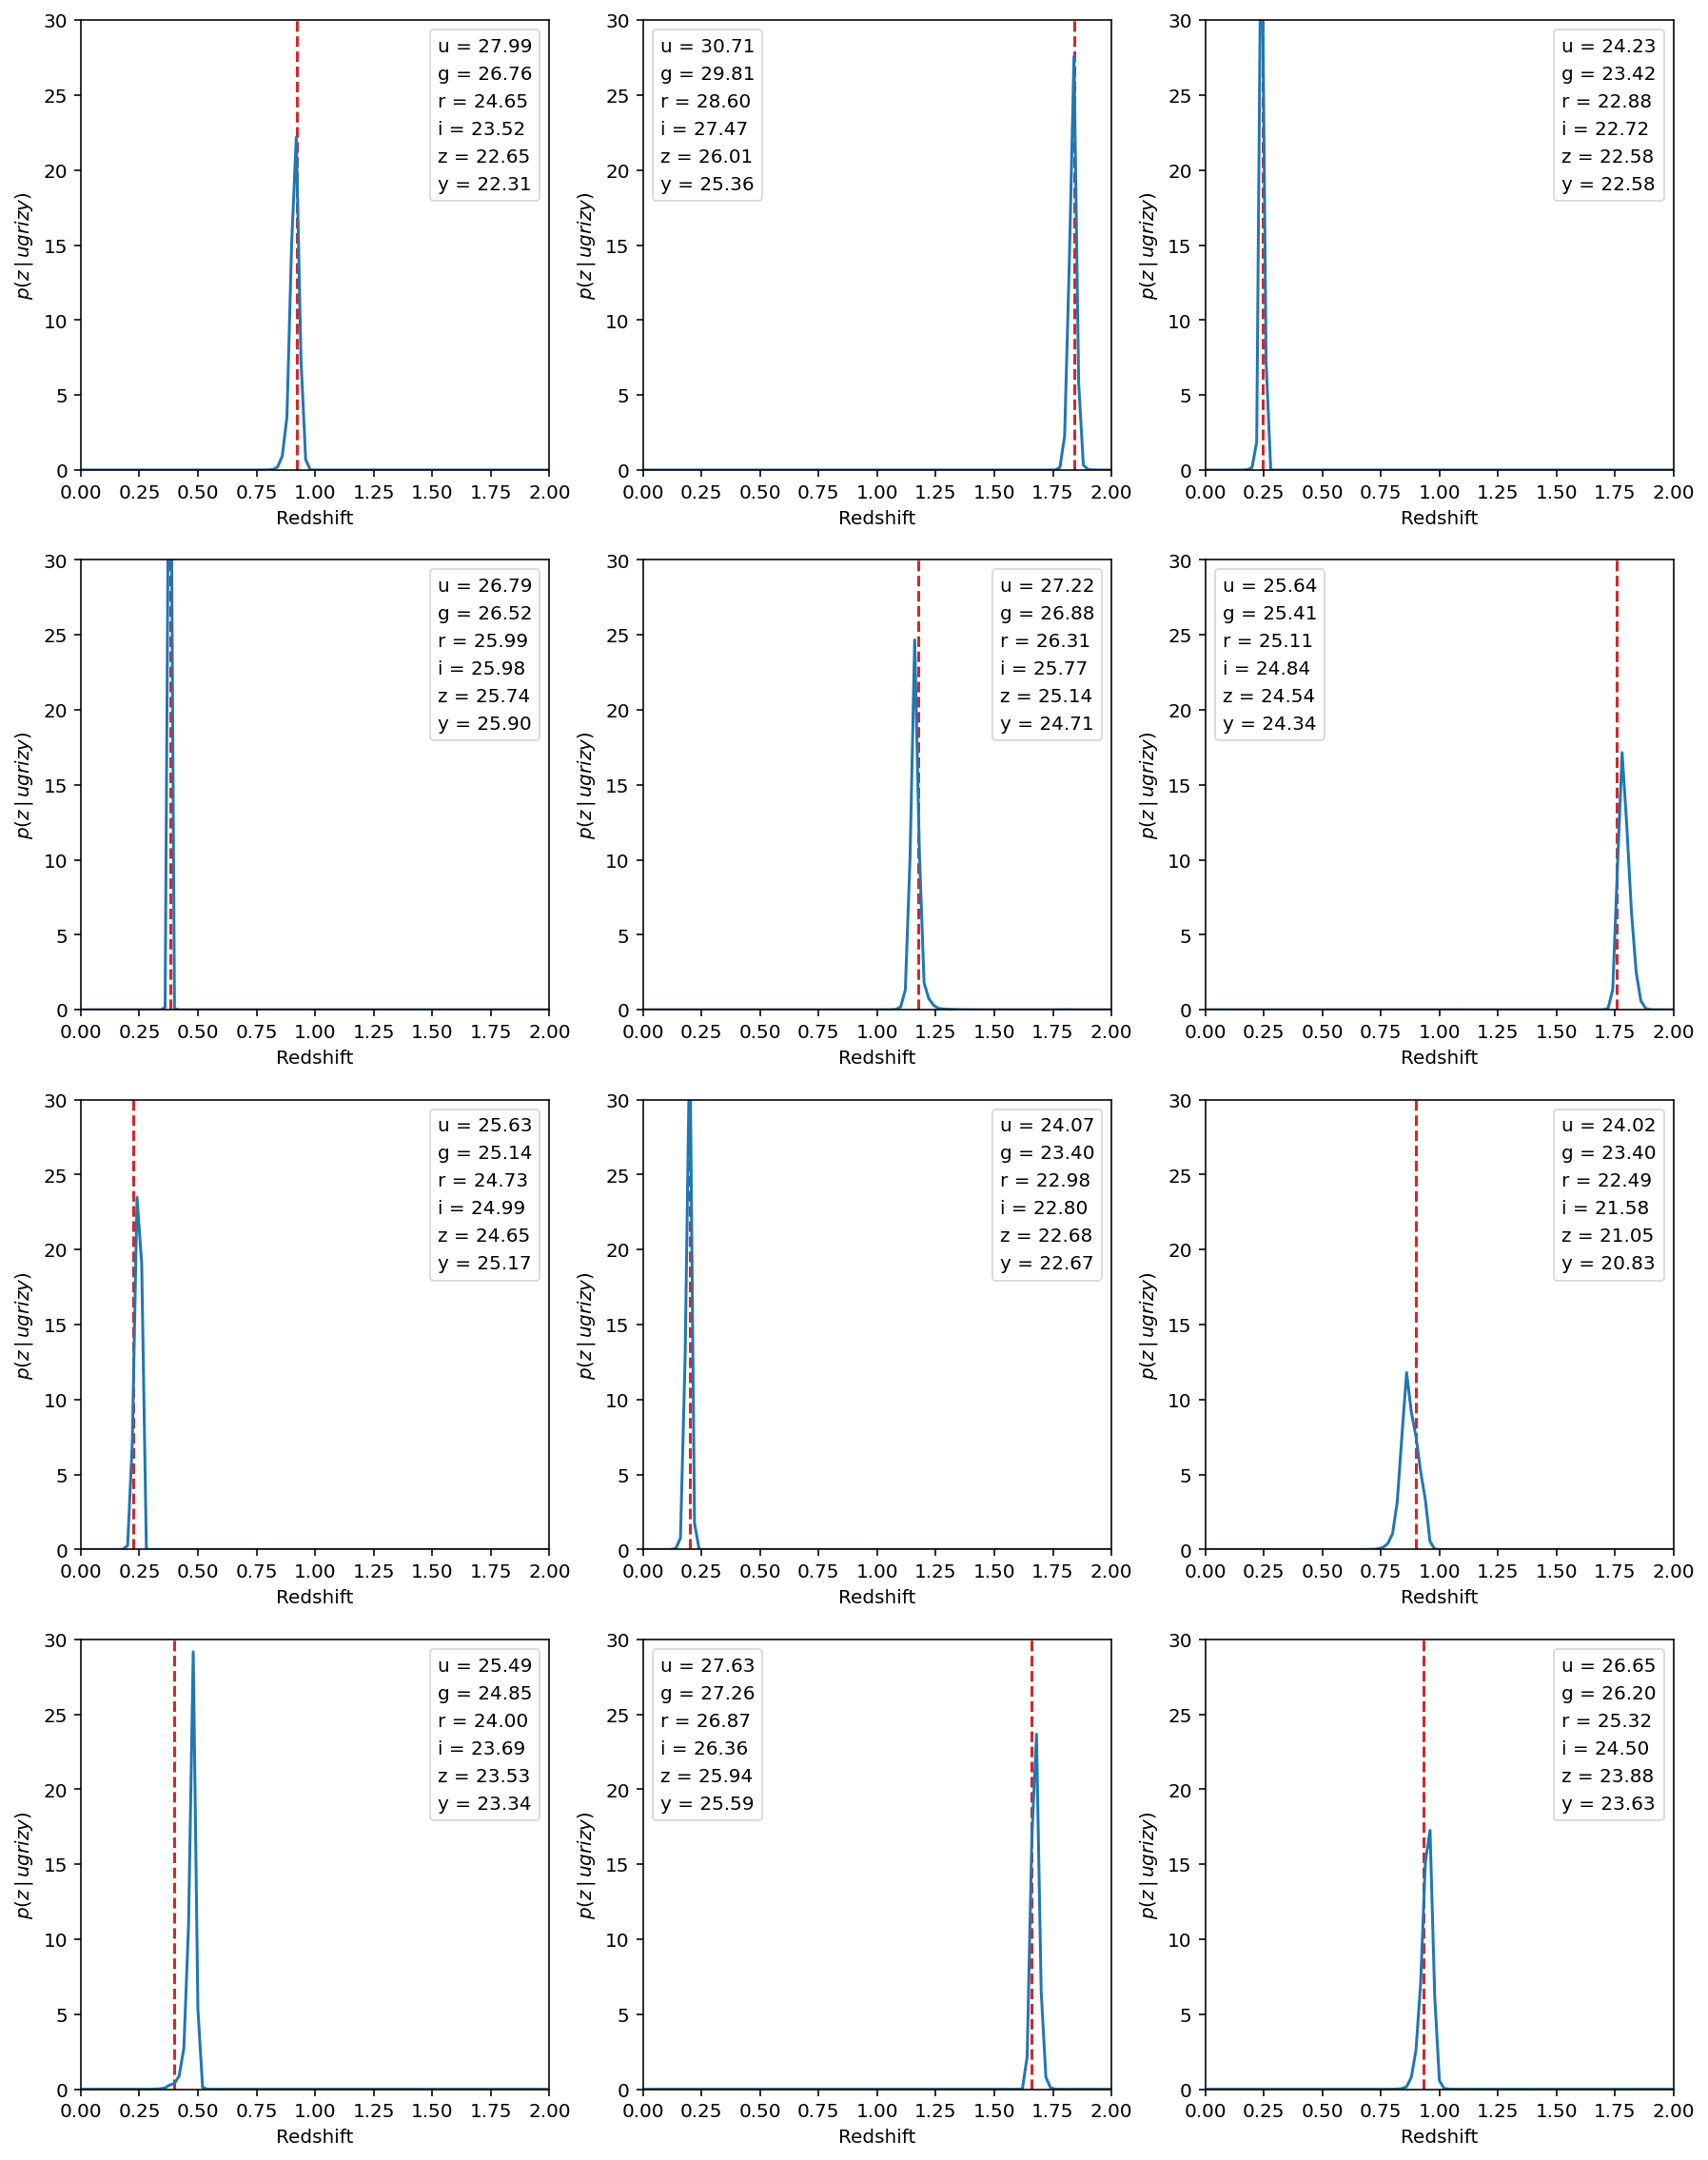

In [14]:
fig,axes = plt.subplots(4, 3, figsize=(15,20))

axes = axes.flatten()

for idx in range(len(axes)):
    
    zs = samples_wPDF.attrs['pz_grid']
    redshift,u,g,r,i,z,y,*_,pz = samples_wPDF.loc[idx]
    axes[idx].plot(zs, pz)
    
    axes[idx].axvline(redshift, c='C3', ls='--', zorder=0)
    
    # create legend with magnitudes
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 6
    labels = []
    band_labels = ['u', 'g', 'r', 'i', 'z', 'y']
    for band,mag in zip(band_labels, [u,g,r,i,z,y]):
        labels.append(f'{band} = {mag:.2f}')
    axes[idx].legend(handles, labels, loc='best', 
              fancybox=True, framealpha=0.7, 
              handlelength=0, handletextpad=0)
    
    axes[idx].set_xlim(0,2)
    axes[idx].set_ylim(0,30)
    axes[idx].set_xlabel("Redshift")
    axes[idx].set_ylabel("$p(z \,|\, ugrizy)$")
    
#fig.savefig('plots/conditional_prob_12.pdf')

In [60]:
maxes = []
for pz in samples_wPDF['pz_pdf']:
    maxes.append(samples_wPDF.attrs['pz_grid'][pz.argmax()])

(0.0, 2.25)

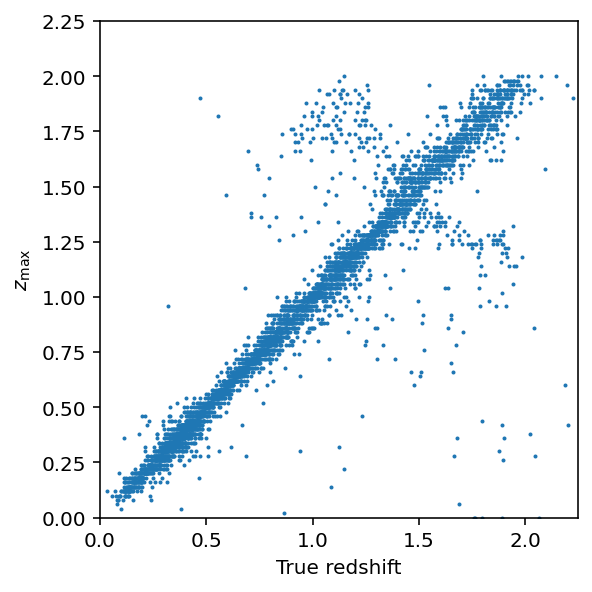

In [61]:
fig,ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ax.scatter(samples_wPDF['redshift'], maxes, s=1)
ax.set_xlabel('True redshift')
ax.set_ylabel('$z_\mathrm{max}$')
ax.set_xlim(0,2.25)
ax.set_ylim(0,2.25)
#fig.savefig('plots/zmax_vs_redshift.pdf')